## What is this?
Experiment to weave nnaudio, timm and fastai together

## What's in this version?
👉 Create transformation function with nnAudio.

👉 Create a custom Transform with fastai.

👉 Check if a custom Dataset can be created using fastai+nnAudio.

## TBD
👉 Dataloader

👉 Learner

👉 Training

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Installing all the required libraries⚙️
👉 Spacy

👉 Fastai

👉 nnAudio

👉 timm

In [2]:
!pip install spacy==3.1.1

     |████████████████████████████████| 6.4 MB 4.6 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 456 kB 54.3 MB/s 
     |████████████████████████████████| 621 kB 54.9 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.5
    Uninstalling thinc-7.4.5:
      Successfully uninstalled thinc-7.4.5
  Attempting uninstall: spacy
    Found existing installation: spacy 2.3.7
    Uninstalling spacy-2.3.7:
      Successfully uninstalled spacy-2.3.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency

In [3]:
#!yes Y|conda install -c fastai fastai=2.4.1
!pip install fastai==2.4.1

     |████████████████████████████████| 188 kB 4.5 MB/s 
     |████████████████████████████████| 22.1 MB 33.0 MB/s 
     |████████████████████████████████| 831.4 MB 1.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.1
    Uninstalling torchvision-0.8.1:
      Successfully uninstalled torchvision-0.8.1
  Attempting uninstall: fastai
    Found existing installation: fastai 2.2.7
    Uninstalling fastai-2.2.7:
      Successfully uninstalled fastai-2.2.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kornia 0.5.5 requires numpy<=1.19, but you have numpy 1.19.5 which is incompatible.
allennlp 2.5.0 requires spacy<3.1,>=2.1.0, but you have spacy 3.1.1 which is incompatible.
all

In [4]:
!pip install timm

     |████████████████████████████████| 376 kB 4.4 MB/s 


In [5]:
!pip install nnaudio

## Import all required modules🖥️

In [6]:
#export
from nnAudio.Spectrogram import CQT
from timm import create_model
from pandas.core.frame import DataFrame
from fastai.vision.all import *

## Get the files🏗️
I will try to grab all the numpy files inside train folder

In [7]:
path = Path("../input")

### Get labels🏗️
Training labels are in the 'training_labels.csv' file.

In [8]:
df = pd.read_csv(path/'g2net-gravitational-wave-detection/training_labels.csv')

In [9]:
df.head(1)

,id,target
0,00000e74ad,1


## getfiles(path: Path, ext)
Get numpy files in `path` recursively, only in `folders`, if specified.

> The "#export" in the function below and all the rest of the functions/code are there to help me use nbdev to export the required codes into a library later.

In [10]:
#export
def getfiles(path: Path, ext):
    "Get numpy files in `path` recursively, only in `folders`, if specified."
    return L(path.glob(f'**/*.{ext}'))

In [11]:
train_path = path/'g2net-gravitational-wave-detection/train'

I am using the previous function to get all the files under the train folder.

In [12]:
%%time
train_files = getfiles(train_path, "npy")

CPU times: user 5.68 s, sys: 2.24 s, total: 7.92 s
Wall time: 1min 42s


Just a quick test to see if we got the correct files.

In [13]:
train_files[:2]

(#2) [Path('../input/g2net-gravitational-wave-detection/train/7/7/7/777d746e90.npy'),Path('../input/g2net-gravitational-wave-detection/train/7/7/7/777ecfbd65.npy')]

Picking labels from the dataframe. We may need thes elabels later or we may not.

In [14]:
labels = df.target.to_list()

## Map path to labels🗺️
To make things easier I will try to map the file paths to their respective labels and create a datafrane out of it.

In [15]:
#export
def map_path_to_labels(data: L, cols: L=None ) -> DataFrame:
    """maps the files to their labels"""
    if cols is None: raise ValueError("You forgot to provide the columns")
    data = dict(zip(cols, data))
    return pd.DataFrame.from_dict(data)

In [16]:
%%time
df = map_path_to_labels([train_files, labels], cols=["id", "target"])

CPU times: user 2.09 s, sys: 6.86 ms, total: 2.09 s
Wall time: 2.09 s


In [17]:
df.head(1)

,id,target
0,../input/g2net-gravitational-wave-detection/train/7/7/7/777d746e90.npy,1


Sample out a subset for quick experiment. Here I wil ltake 20,000 samples.

In [18]:
sample = df[:20000]

In [19]:
sample.shape

(20000, 2)

In [20]:
sample.head(1)

,id,target
0,../input/g2net-gravitational-wave-detection/train/7/7/7/777d746e90.npy,1


## Q transform using nnaudio⚗️
We will design a transformstion function that would get the q transform of the time series on the fly using nnaudio.
The result will be similar to converting the time series data into images.

Code taken from [notebook](https://www.kaggle.com/yasufuminakama/g2net-efficientnet-b7-baseline-training) shared by [Y.Nakama](https://www.kaggle.com/yasufuminakama)

In [21]:
#export
def qtfms(o):
    """convert waves to images"""
    waves = np.load(o)
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    cqt = CQT(sr=2048,  hop_length=64, fmin=20, fmax=1024)
    image = cqt(waves)
    return image

Quick test to see if this works.

CQT kernels created, time used = 0.0153 seconds


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


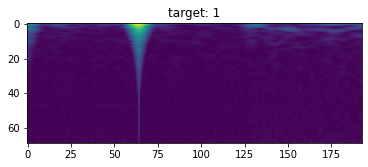

CQT kernels created, time used = 0.0124 seconds


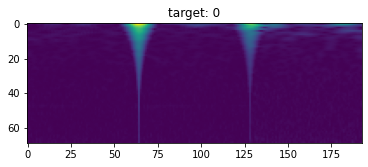

CQT kernels created, time used = 0.0129 seconds


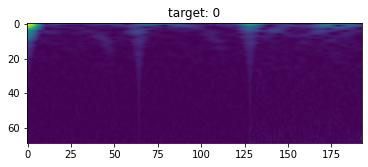

CQT kernels created, time used = 0.0131 seconds


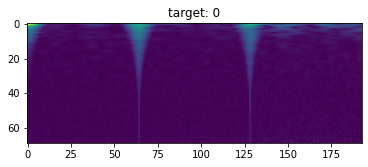

CQT kernels created, time used = 0.0133 seconds


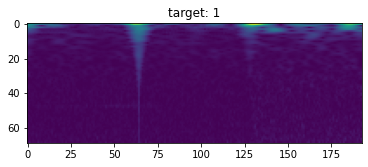

In [22]:
for i in range(5):
    image = qtfms(sample.loc[i, 'id'])
    target = sample.loc[i, 'target']
    plt.imshow(image[0])
    plt.title(f"target: {target}")
    plt.show()

Cool! so we are able to plot the images now. IT is fast too.

## Creating the dataset🖫
If you want to use fastai's learner to train your model on the transfomed spectograms, you can do so by creating a custom Dataset in pytorch and then feeding that dataset with a dataloader to fastai's learner. However, if you create a pipeline using fastai's internals then you get to use some cool functionalities out-of-box. We will see that in a while.

All the code below are very heavily insipired by the original inspiration of this notebook (see the very first section), this [post](https://ohmeow.com/posts/2020/04/11/finding-datablock-nirvana-part-1.html) by Wayde Gilliam and the fastai s[iamese tutorial](https://docs.fast.ai/tutorial.siamese.html#Writing-your-custom-data-block).

In [23]:
sample.loc[1]['id']

Path('../input/g2net-gravitational-wave-detection/train/7/7/7/777ecfbd65.npy')

## NNAudioImage(fastuple)
First of all we are going to create an "Image type" for our transformed object (it's the numpy data transformed into spectogram). We have to do this because our dat ais not an image data from get-go. Rather it's a signal data which we are transforming into an Imgae. So, in order to tell fastai that this is a custom Image type which we are dealing with and ho wwe should be displaying it, we have to create an Image type.

In [24]:
#export
class NNAudioImage(fastuple):
    """Custom Image for nnAudio transformed signals"""
    def show(self, ctx=None, **kwargs):
        img, category = self
        if not isinstance(img, Tensor):
            img_tensor = tensor(img)
        else: 
            img_tensor = img    
        return show_image(img_tensor, title=category, ctx=ctx, **kwargs)

## NNAudioDataset
One of the way to create a Dataset in fastai is to create a custom transform by inheriting from the `Transform` class. Creating a `Transform` has come advantages as compared to a pytorch Dataset like you don't need to have a `len` component or a `get_item` component.

On a very high level a `Transform` has an `encodes`, `decodes` and `setup` methods. For our purpose having an `encodes` methods only would suffice. This is the place where we would be transforming the numpy data into spectograms.

To know more about `Tranforms` refer these -->
* [data block nirvana](https://ohmeow.com/posts/2020/04/11/finding-datablock-nirvana-part-1.html)
* [Siamese tutorial](https://docs.fast.ai/tutorial.siamese.html#Writing-your-custom-data-block)
* [Fastbook chapter-11](https://github.com/fastai/fastbook/blob/master/11_midlevel_data.ipynb)

In [25]:
#export
class NNAudioTransform(Transform):
    """Custom Transform which uses nnAudio transforms
    to extract spectogram on the fly"""
    def __init__(self, df, x_col:str, y_col: str):
        self.df = df
        self.x_col = x_col
        self.y_col = y_col

    def encodes(self, img_path):
        label = self.df[self.df[self.x_col] == img_path][self.y_col].values[0]
        img = qtfms(img_path)
        img = img.squeeze().numpy()
        return NNAudioImage(img, label)

Look how we can use the `NNAudioImage` class to tell fastai Transform about the type of data which we want to get.

Now that we have a transform, we will use an object known as `TfmdLists` to create our Dataset. 
> A `TfmdLists` lazily applies all our transforms to our a list of items. 

We will also use a 'splitter' which tells fastai the way we want to split our data. For now we will use `RandomSplitter` to do this job. Additionally we will also instantiate the `NNAudioTransform` object.

In [26]:
splits = RandomSplitter()(sample.id.to_list())
tfm = NNAudioTransform(sample,'id', 'target')

Next, we have to tell fastai to take our 'sample' and apply the transform and the splitter to it.

In [27]:
tls = TfmdLists(sample.id.to_list(), tfm, splits=splits)

CQT kernels created, time used = 0.0133 seconds


Now that we have a Dataset in place, we can grab an item out of it and view it by using `show_at` method.

CQT kernels created, time used = 0.0128 seconds


<AxesSubplot:title={'center':'1'}>

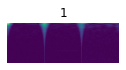

In [28]:
show_at(tls.train, 1)

Let's plot with vanialla matplotlib to check if we get the same image.

CQT kernels created, time used = 0.0137 seconds


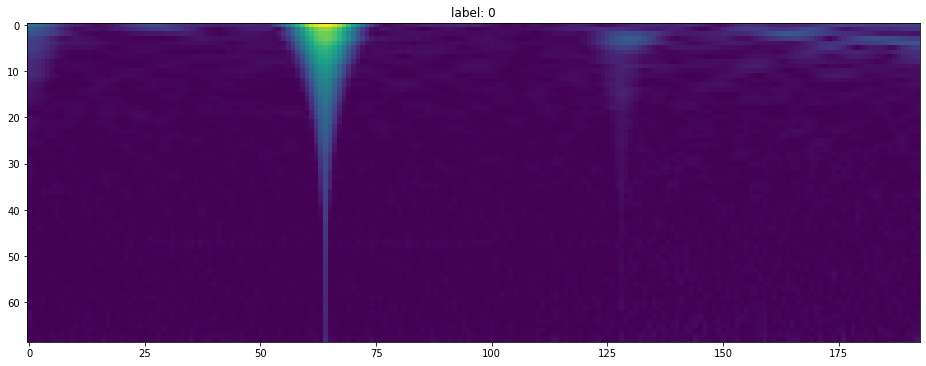

In [29]:
plt.figure(figsize=(16,12))
image,label = tls.train[i]
plt.imshow(image)
plt.title(f'label: {label}')
plt.show() 

So, we are all good. We can now create a custom fastai Dataset and display the data in it.

## Create the Dataloader🖨️
We can use the `TfmdLists` to create a dataloader by calling `dataloaders()`. Here we can't apply `item_tfms` or `batch_tfms` but we can get the hooks to different point in time of the pipeline and can put our transforms there.

For example, once items are grabbed then that moment is known as "after_item". We can use this hook to apply our transforms once items are grabbed.

In [30]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
                     after_batch=[IntToFloatTensor])

CQT kernels created, time used = 0.0148 seconds


One more thing that we need to do is to make the `show_batch` method aware of the type of our Image. This can be easily done by using `typedispatch` to dispatch our `show_batch` (the one which we will override with our image type). 

In [31]:
@typedispatch
def show_batch(x:NNAudioImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=3, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        NNAudioImage(x[0][i], x[1][i].item()).show(ctx=ctx)

`typedispatch` does somethign similar to [multi-dispatch](https://en.wikipedia.org/wiki/Multiple_dispatch). So, that whenever we call the `show_batch` on our image type then fastai will call our version of `show_batch` after recognizing our image type.

Here we go

CQT kernels created, time used = 0.0155 seconds
CQT kernels created, time used = 0.0136 seconds
CQT kernels created, time used = 0.0131 seconds
CQT kernels created, time used = 0.0128 seconds
CQT kernels created, time used = 0.0133 seconds
CQT kernels created, time used = 0.0168 seconds
CQT kernels created, time used = 0.0136 seconds
CQT kernels created, time used = 0.0131 seconds
CQT kernels created, time used = 0.0129 seconds
CQT kernels created, time used = 0.0131 seconds
CQT kernels created, time used = 0.0127 seconds
CQT kernels created, time used = 0.0132 seconds
CQT kernels created, time used = 0.0138 seconds
CQT kernels created, time used = 0.0131 seconds
CQT kernels created, time used = 0.0129 seconds
CQT kernels created, time used = 0.0131 seconds
CQT kernels created, time used = 0.0152 seconds
CQT kernels created, time used = 0.0133 seconds
CQT kernels created, time used = 0.0134 seconds
CQT kernels created, time used = 0.0120 seconds
CQT kernels created, time used = 0.0125 

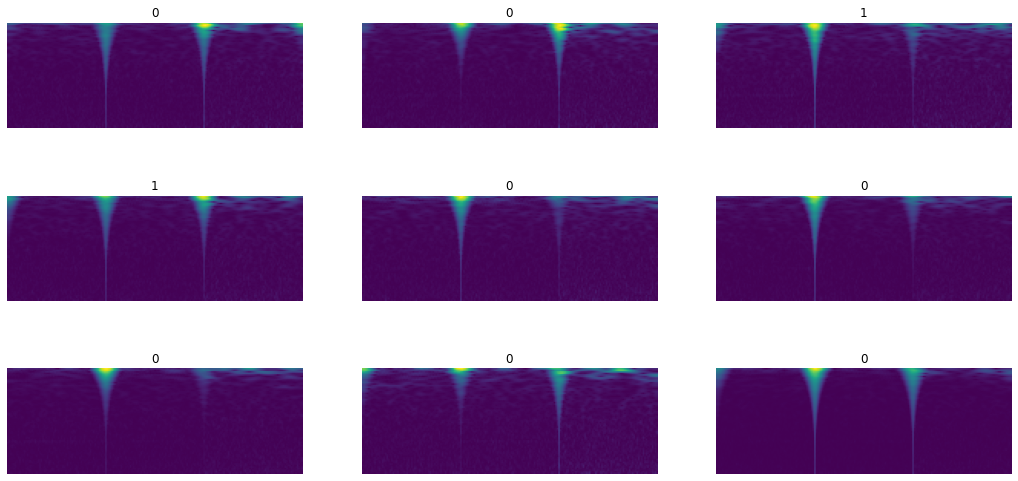

In [32]:
dls.show_batch()

One thing thats annoying me is that I still don't know how to suppress the output that nnAudio throws while processing the spectograms.

## TBD🎈🎈
👉 Create Learner

👉 Training